<Axes: >

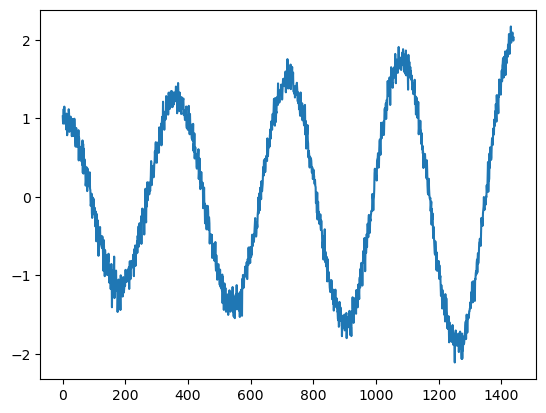

In [1]:
#%% Packages
import numpy as np 
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
# %% simple dataset
num_points = 360*4
X = np.arange(num_points)
y = [np.cos(X[i]*np.pi/180) * (1+i/num_points) + (np.random.randn(1)*0.1)[0] for i in range(len(X))]
sns.lineplot(x=X, y=y)


In [2]:
# %% Data Restructuring
X_restruct = [] 
y_restruct = [] 

for i in range(num_points-10):
     list1 = []
     for j in range(i,i+10):
         list1.append(y[j])
     X_restruct.append(list1)
     y_restruct.append(y[j+1])
X_restruct = np.array(X_restruct)
y_restruct = np.array(y_restruct)
# %% Train / Test Split
train_test_clipping = 360*3
X_train = X_restruct[:train_test_clipping]
X_test = X_restruct[train_test_clipping:]
y_train = y_restruct[:train_test_clipping]
y_test = y_restruct[train_test_clipping:]


# display all size of dataset
print("X_train: ", X_train.shape, "y_train: ", y_train.shape, "X_test: ", X_test.shape, "y_test: ", y_test.shape)

X_train:  (1080, 10) y_train:  (1080,) X_test:  (350, 10) y_test:  (350,)


In [11]:

#%% Create Dataset and Dataloader
# Dataset 
class TrigonometricDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Dataloader
train_loader = DataLoader(TrigonometricDataset(X_train, y_train), batch_size=3)
test_loader = DataLoader(TrigonometricDataset(X_test, y_test), batch_size=len(y_test))



<Axes: >

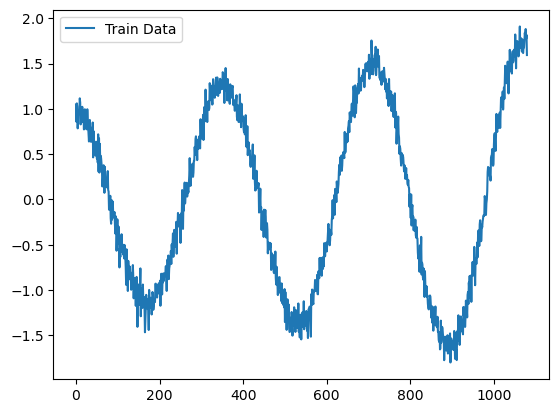

In [12]:
#%% visualize train data
sns.lineplot(x=range(len(y_train)), y=y_train, label = 'Train Data')


In [13]:
# %% Model
class TrigonometryModel(nn.Module):
    def __init__(self, input_size=1, output_size=1):
        super(TrigonometryModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size=5, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(in_features=5, out_features=output_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x, status = self.lstm(x)    
        x = x[:, -1, :]  # reshape for fc layer; out: BS, hidden
        x = self.fc1(x)
        x = self.relu(x)

        return x

# Check if CUDA is available and set PyTorch to use GPU or CPU accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#%% instantiate model, optimizer, and loss
model = TrigonometryModel()
# input = torch.rand((3, 10, 1))  # BS, seq_len, input_size
# model(input).shape  # out: [BS, seq_len, hidden]


#%% Loss and Optimizer
loss_fun = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
NUM_EPOCHS = 100


#%% Loss and Optimizer
loss_fun = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
NUM_EPOCHS = 30

#%% Train
for epoch in range(NUM_EPOCHS):
    for j, (X, y) in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = model(X.view(-1, 10, 1))
        loss = loss_fun(y_pred, y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        if j % len(train_loader) == 0:
           print(f"Epoch: {epoch}, Loss: {loss.data}")
  



Epoch: 0, Loss: 0.5448121428489685
Epoch: 1, Loss: 0.5250369906425476
Epoch: 2, Loss: 0.5032175183296204
Epoch: 3, Loss: 0.47130587697029114
Epoch: 4, Loss: 0.42295145988464355
Epoch: 5, Loss: 0.3634045422077179
Epoch: 6, Loss: 0.2957618534564972
Epoch: 7, Loss: 0.22233812510967255
Epoch: 8, Loss: 0.14821279048919678
Epoch: 9, Loss: 0.08354544639587402
Epoch: 10, Loss: 0.03907904773950577
Epoch: 11, Loss: 0.01711336150765419
Epoch: 12, Loss: 0.010189241729676723
Epoch: 13, Loss: 0.01046184916049242
Epoch: 14, Loss: 0.013332001864910126
Epoch: 15, Loss: 0.016694827005267143
Epoch: 16, Loss: 0.019729282706975937
Epoch: 17, Loss: 0.02197234146296978
Epoch: 18, Loss: 0.02338535524904728
Epoch: 19, Loss: 0.024118594825267792
Epoch: 20, Loss: 0.024316268041729927
Epoch: 21, Loss: 0.02416742593050003
Epoch: 22, Loss: 0.023770896717905998
Epoch: 23, Loss: 0.023228762671351433
Epoch: 24, Loss: 0.02260364592075348
Epoch: 25, Loss: 0.021915869787335396
Epoch: 26, Loss: 0.02126057632267475
Epoch: 

In [14]:

# %% Create Predictions
test_set = TrigonometricDataset(X_test, y_test)
X_test_torch, y_test_torch = next(iter(test_loader))
with torch.no_grad():
    y_pred = model(torch.unsqueeze(X_test_torch, 2)).detach().squeeze().numpy()
y_act = y_test_torch.numpy()
x_act = range(y_act.shape[0])


<Axes: >

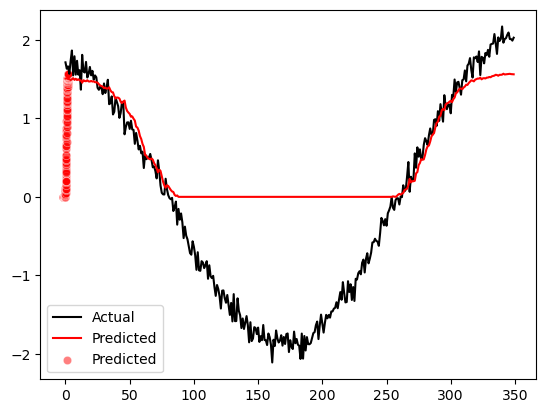

In [15]:
sns.lineplot(x=x_act, y=y_act, label = 'Actual',color='black')
sns.lineplot(x=x_act, y=y_pred, label = 'Predicted',color='red')

# %% correlation plot
sns.scatterplot(x=y_act, y=y_pred, label = 'Predicted',color='red', alpha=0.5)
# %%